<a href="https://colab.research.google.com/github/ErChitraDhir/demo-repo/blob/main/Lip_Verbalizer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Install and import Dependencies:


In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from PIL import Image

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices=tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

1. Build data loading functions:

In [6]:
import gdown

In [7]:
url='https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output='data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:04<00:00, 93.3MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str)-> List[float]:

  cap=cv2.VideoCapture(path)
  frames=[]
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame=cap.read()
    frame=tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  cap.release()

  mean=tf.math.reduce_mean(frames)
  std=tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames-mean),tf.float32)/ std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char =tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="", invert=True)

print(f"the vocabulary is:{char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()})")

the vocabulary is:['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40)


In [12]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [13]:
char_to_num(['a','b','c'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>

In [14]:
num_to_char([1,2,3,4])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'b', b'c', b'd'], dtype=object)>

In [15]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [16]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [17]:
test_path='./data/s1/bbaf2n.mpg'

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [19]:
frames,alignments=load_data(tf.convert_to_tensor(test_path))

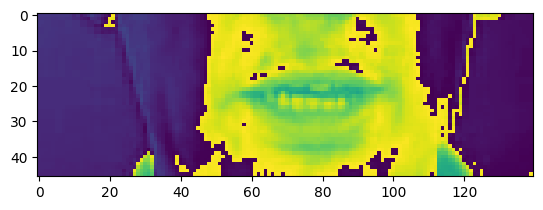

In [20]:
plt.imshow(frames[50])

In [21]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [22]:
print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

tf.Tensor(b'bin blue at f two now', shape=(), dtype=string)


In [23]:
print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

tf.Tensor(b'bin blue at f two now', shape=(), dtype=string)


In [24]:
def mappable_function(path:str)-> List[str]:
  result=tf.py_function(load_data,[path],(tf.float32,tf.int64))
  return result

2. Create Data Pipeline:

In [25]:
from matplotlib import pyplot as plt

In [26]:
data=tf.data.Dataset.list_files('./data/s1/*.mpg')
data=data.shuffle(500,reshuffle_each_iteration=False)
data=data.map(mappable_function)
data=data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data=data.prefetch(tf.data.AUTOTUNE)
train=data.take(450)
test=data.skip(450)

In [27]:
len(test)

50

In [28]:
frames,alignments = data.as_numpy_iterator().next()

In [29]:
frames

array([[[[[ 1.4407172 ],
          [ 1.4407172 ],
          [ 1.4407172 ],
          ...,
          [10.4966545 ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.4407172 ],
          [ 1.4407172 ],
          [ 1.4407172 ],
          ...,
          [10.4966545 ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.3583906 ],
          [ 1.3583906 ],
          [ 1.3583906 ],
          ...,
          [10.4966545 ],
          [10.4966545 ],
          [10.4966545 ]],

         ...,

         [[ 0.9879204 ],
          [ 0.9879204 ],
          [ 0.9879204 ],
          ...,
          [10.20851   ],
          [10.20851   ],
          [10.20851   ]],

         [[ 0.9879204 ],
          [ 0.9879204 ],
          [ 0.9879204 ],
          ...,
          [10.167348  ],
          [10.167348  ],
          [10.167348  ]],

         [[ 0.9879204 ],
          [ 0.9879204 ],
          [ 0.9879204 ],
          ...,
          [10.167348  ],
          [10.167348  ],
          

In [30]:
alignments

array([[ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  2, 25, 39,  8, 39, 15,
        14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39, 15, 39, 19,
         5, 22,  5, 14, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [31]:
#plt.imshow(frames[0])
len(frames)

2

In [32]:
test=data.as_numpy_iterator()

In [33]:
val=test.next();val[0]

array([[[[[ 1.4464353 ],
          [ 1.4464353 ],
          [ 1.4866141 ],
          ...,
          [ 0.20089379],
          [ 0.16071503],
          [ 0.16071503]],

         [[ 1.4464353 ],
          [ 1.4464353 ],
          [ 1.4866141 ],
          ...,
          [ 0.20089379],
          [ 0.16071503],
          [ 0.16071503]],

         [[ 1.4866141 ],
          [ 1.4866141 ],
          [ 1.4464353 ],
          ...,
          [ 0.24107255],
          [ 0.24107255],
          [ 0.24107255]],

         ...,

         [[ 1.0446477 ],
          [ 1.0044689 ],
          [ 1.0044689 ],
          ...,
          [10.245584  ],
          [10.245584  ],
          [10.245584  ]],

         [[ 1.0044689 ],
          [ 1.0044689 ],
          [ 1.0044689 ],
          ...,
          [10.245584  ],
          [10.245584  ],
          [10.245584  ]],

         [[ 1.0044689 ],
          [ 1.0044689 ],
          [ 1.0044689 ],
          ...,
          [10.245584  ],
          [10.245584  ],
          

In [34]:
imageio.mimsave

<function imageio.v2.mimwrite(uri, ims, format=None, **kwargs)>

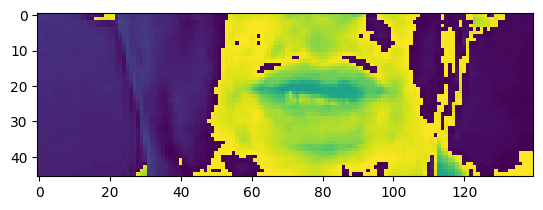

In [35]:
plt.imshow(val[0][0][35])

In [36]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y two now'>

3. Design the Deep Neural Network:

In [37]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [38]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [39]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [41]:
yhat=model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [43]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'bbbb???????????????????????????????????????????????????????????????????????'>

In [44]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'bbbb???????????????????????????????????????????????????????????????????????'>

In [45]:
model.input_shape

(None, 75, 46, 140, 1)

In [46]:
model.output_shape

(None, 75, 41)

4.Setup training options and train:

In [47]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [48]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [49]:
import tensorflow as tf

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [50]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [51]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [52]:
schedule_callback = LearningRateScheduler(scheduler)

In [53]:
example_callback = ProduceExample(data)

In [ ]:
 model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

 47/450 [==>...........................] - ETA: 3:34:07 - loss: 121.7404

5.Make Predictions and Test Time:

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:02<00:00, 36.5MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
hat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

Test on a Video:

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]